# jobflow

## Define workflow with jobflow

In [1]:
from jobflow import job, Flow

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
from python_workflow_definition.jobflow import write_workflow_json

In [ ]:
from arithmetic_workflow import (
    get_sum as _get_sum,
    get_prod_and_div as _get_prod_and_div,
)

In [ ]:
workflow_json_filename = "jobflow_simple.json"

In [5]:
get_sum = job(_get_sum)
get_prod_and_div = job(_get_prod_and_div, data=["prod", "div"])

In [6]:
obj = get_prod_and_div(x=1, y=2)

In [7]:
w = get_sum(x=obj.output.prod, y=obj.output.div)

In [8]:
flow = Flow([obj, w])

In [9]:
write_workflow_json(flow=flow, file_name=workflow_json_filename)

In [10]:
!cat {workflow_json_filename}

{"nodes": [{"id": 0, "function": "arithmetic_workflow.get_prod_and_div"}, {"id": 1, "function": "arithmetic_workflow.get_sum"}, {"id": 2, "value": 1}, {"id": 3, "value": 2}], "edges": [{"target": 0, "targetPort": "x", "source": 2, "sourcePort": null}, {"target": 0, "targetPort": "y", "source": 3, "sourcePort": null}, {"target": 1, "targetPort": "x", "source": 0, "sourcePort": "prod"}, {"target": 1, "targetPort": "y", "source": 0, "sourcePort": "div"}]}

## Load Workflow with aiida

In [11]:
from aiida import load_profile

load_profile()

Profile<uuid='5b8a8d98b3014876a9eed7d85a954e5e' name='pwd'>

In [12]:
from python_workflow_definition.aiida import load_workflow_json

In [13]:
wg = load_workflow_json(file_name=workflow_json_filename)
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'WorkGra…

In [14]:
wg.run()

04/23/2025 09:35:55 AM <2073> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_prod_and_div1
04/23/2025 09:35:56 AM <2073> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|update_task_state]: Task: get_prod_and_div1, type: PyFunction, finished.
04/23/2025 09:35:56 AM <2073> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_sum2
04/23/2025 09:35:56 AM <2073> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|update_task_state]: Task: get_sum2, type: PyFunction, finished.
04/23/2025 09:35:56 AM <2073> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
04/23/2025 09:35:56 AM <2073> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3|WorkGraphEngine|finalize]: Final

## Load Workflow with pyiron_base

In [15]:
from python_workflow_definition.pyiron_base import load_workflow_json

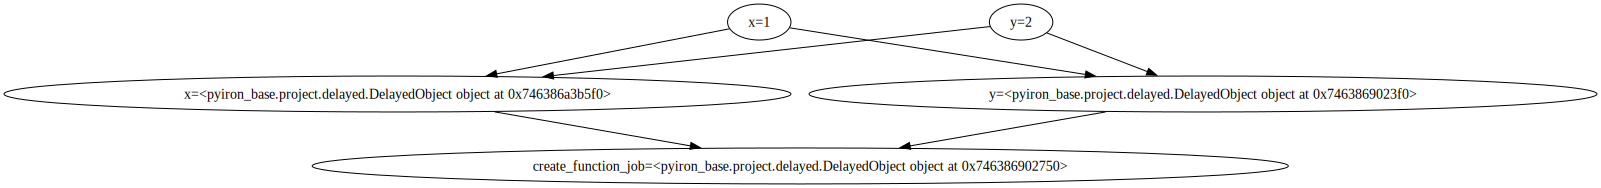

In [16]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [17]:
delayed_object_lst[-1].pull()

The job get_prod_and_div_955f44280fa0072653e4d910a57d7b92 was saved and received the ID: 1
The job get_sum_55b699570ac3c74e1e8078a45b657240 was saved and received the ID: 2


2.5